In [144]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
from tqdm import tqdm
from preprocessing import PastUserState,extract_data_mooc,PreviousItemInteraction, extractFeatures,extractItemUserId,extractNextStateItem,extractNextUserState,UserNextInteraction, delta, t_batch_update,train_test_split,train_test_stratified_split
from model import RODIE
from sklearn.manifold import TSNE
from train import dynamic_embedding,train_rodie
from  torch import nn
from torch.nn import RNNCell
from torch.nn.functional import one_hot
import math
from torch.nn import functional as F
from torch.nn import MSELoss, HuberLoss,L1Loss,CrossEntropyLoss
from tqdm import tqdm


torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [ ]:
## Téléchargement des données
!wget https://snap.stanford.edu/data/act-mooc.tar.gz
!tar -xzf  act-mooc.tar.gz
!mkdir data

--2022-03-21 12:46:43--  https://snap.stanford.edu/data/act-mooc.tar.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5378133 (5.1M) [application/x-gzip]
Saving to: ‘act-mooc.tar.gz’

act-mooc.tar.gz     100%[===================>]   5.13M  4.75MB/s    in 1.1s    

2022-03-21 12:46:44 (4.75 MB/s) - ‘act-mooc.tar.gz’ saved [5378133/5378133]



In [145]:
features = pd.read_csv("act-mooc/mooc_action_features.tsv",sep="\t")
labels = pd.read_csv("act-mooc/mooc_action_labels.tsv",sep="\t")
users = pd.read_csv("act-mooc/mooc_actions.tsv",sep="\t")

#### Load & Preprocess Data

In [146]:
mooc_data = extract_data_mooc()


In [147]:
delta_u  = delta(mooc_data.copy(),"user_id")
delta_i  = delta(mooc_data.copy(),"item_id")
PreviousItemInteraction_ = PreviousItemInteraction(mooc_data.copy()).astype(int)
next_state_user = PastUserState(mooc_data.copy()).astype(int)

interaction_column_name = "PreviousItemInteraction"
pastState_column_name =  "previous_state_label"

delta user_id
delta item_id


In [ ]:
mooc_data['delta_u'] = delta_u/np.std(delta_u)
mooc_data['delta_i'] = delta_i/np.std(delta_i)
mooc_data[interaction_column_name] = PreviousItemInteraction_
mooc_data[pastState_column_name] = next_state_user
list_moins_un = list(mooc_data[mooc_data[pastState_column_name] == -1].index.values)
mooc_data.loc[list_moins_un,pastState_column_name] = 0
data = mooc_data.copy()
#data = data[data.next_state_user != -1]

data = data[['user_id', 'item_id', 'timestamp', 'state_label','delta_u', 'delta_i', interaction_column_name, pastState_column_name,'f1', 'f2', 'f3','f4']].sort_values(['timestamp'])
data

### T-batches

#### Train / Test SPLIT

In [161]:
t_batches_train = t_batch_update(data)


T-Batch start...
Number of interaction = 411749
T-Batch ends !


In [162]:
len(t_batches_train)

63461

##### Initialize Device

In [163]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
print('Using device:', device)

Using device: cuda


##### Initialize the model

In [197]:
# Test le modèle sur peu de données
import itertools
interactions_ = []
n_batches = 11500
t_batches_ = dict(itertools.islice(t_batches_train.items(), n_batches))
number_of_interactions = 0
for x,y in t_batches_.items():
  number_of_interactions +=(len(y))
  interactions_.append(y)
interactions = list(itertools.chain(*interactions_)) # Flatten the list of list
print("Number of interactions in {} batches is equal to {}".format(n_batches,number_of_interactions))

Number of interactions in 11500 batches is equal to 57363


In [198]:
# Its important to add this to the loss, because the dataset is unbalanced
dropout_ratio = len(interactions)/(1.0+ np.sum(data.loc[interactions,'state_label']))
weight_ratio = torch.Tensor([1.0,dropout_ratio]).to(device)
print("Number of dropout in the train data is {}".format(np.sum(data.loc[interactions,'state_label'])))

Number of dropout in the train data is 572


In [199]:
embedding_dim = 8
data_torch = torch.from_numpy(data.values.astype(np.float32))
model = RODIE(embedding_dim,data_torch,device=device,activation_rnn="tanh").to(device)

Number of users of 7047 
 Number of items 97 

Dataset size [411749, 12]
Initialisation of static embedding... Done !
Static Embedding shape : Users [7047, 7047], 	 Items [98, 98]
Initialisation of rnn's with tanh activation function... Done !
Initialisation of MLP... Done !


##### Train Loop

In [216]:
n_epochs = 10
lambda_u = 1e-1
lambda_i = 1e-1
learning_rate=1e-3
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-5)

model_,U,I = train_rodie(t_batches_,
          data_torch,
          weight_ratio,
          model,
          optimizer,
          learning_rate,
          n_epochs,
          lambda_u,
          lambda_i,
          device
          )

Initialisation of dynamic embedding... Done !
Dynamic Embedding shape : Users [7047, 8], 	 Items [98, 8]
Training...


100%|█████████▉| 11499/11500 [01:29<00:00, 128.56it/s]


tensor([-0.0651,  0.7296,  0.1638,  0.0634,  0.2287,  0.4130,  0.2216, -0.4008],
       device='cuda:0') tensor([-0.0612, -0.3933,  0.4455,  0.3657,  0.0136, -0.5762, -0.2869, -0.3080],
       device='cuda:0')
Epoch 0 Loss 2253.409471509047


100%|█████████▉| 11499/11500 [01:27<00:00, 131.87it/s]


tensor([ 0.0182,  0.6179,  0.2106, -0.0219,  0.3027,  0.3903,  0.3004, -0.4887],
       device='cuda:0') tensor([ 0.0058, -0.4225,  0.3741,  0.4260, -0.0512, -0.4877, -0.3673, -0.3531],
       device='cuda:0')
Epoch 1 Loss 2201.7532369084656


100%|█████████▉| 11499/11500 [01:27<00:00, 131.49it/s]


tensor([-0.0081,  0.6025,  0.2245, -0.0377,  0.3440,  0.4253,  0.3451, -0.4084],
       device='cuda:0') tensor([ 0.3510, -0.3678, -0.3245,  0.3712, -0.3524,  0.3150, -0.3744, -0.3672],
       device='cuda:0')
Epoch 2 Loss 2196.5553723268677


100%|█████████▉| 11499/11500 [01:27<00:00, 132.16it/s]


tensor([ 0.1266,  0.5852,  0.1882,  0.0377,  0.3427,  0.4171,  0.3392, -0.4452],
       device='cuda:0') tensor([ 0.3511, -0.3723, -0.3158,  0.3758, -0.3515,  0.3074, -0.3754, -0.3718],
       device='cuda:0')
Epoch 3 Loss 2190.0644325725734


100%|█████████▉| 11499/11500 [01:29<00:00, 128.26it/s]


tensor([ 0.1379,  0.5901,  0.1834,  0.0126,  0.3341,  0.4008,  0.3411, -0.4586],
       device='cuda:0') tensor([ 0.3525, -0.3579, -0.3439,  0.3587, -0.3524,  0.3399, -0.3633, -0.3592],
       device='cuda:0')
Epoch 4 Loss 2186.313209053129


100%|█████████▉| 11499/11500 [01:27<00:00, 131.49it/s]


tensor([ 0.1521,  0.5588,  0.1776,  0.0602,  0.3498,  0.3982,  0.3433, -0.4802],
       device='cuda:0') tensor([ 0.3542, -0.3563, -0.3439,  0.3586, -0.3529,  0.3400, -0.3628, -0.3592],
       device='cuda:0')
Epoch 5 Loss 2189.1884494517


100%|█████████▉| 11499/11500 [01:29<00:00, 128.15it/s]


tensor([ 0.1730,  0.5256,  0.1901,  0.0571,  0.3409,  0.4245,  0.3565, -0.4806],
       device='cuda:0') tensor([ 0.3539, -0.3625, -0.3347,  0.3648, -0.3542,  0.3272, -0.3674, -0.3617],
       device='cuda:0')
Epoch 6 Loss 2184.001758951228


100%|█████████▉| 11499/11500 [01:29<00:00, 128.88it/s]


tensor([ 0.1921,  0.4964,  0.2329,  0.0930,  0.3786,  0.4084,  0.3698, -0.4548],
       device='cuda:0') tensor([ 0.3516, -0.3627, -0.3335,  0.3655, -0.3551,  0.3264, -0.3669, -0.3643],
       device='cuda:0')
Epoch 7 Loss 2184.1193003673106


100%|█████████▉| 11499/11500 [01:29<00:00, 128.46it/s]


tensor([ 0.2304,  0.4807,  0.2432,  0.0330,  0.3942,  0.3815,  0.4033, -0.4381],
       device='cuda:0') tensor([ 0.3533, -0.3627, -0.3350,  0.3646, -0.3539,  0.3281, -0.3664, -0.3623],
       device='cuda:0')
Epoch 8 Loss 2185.0546468906105


100%|█████████▉| 11499/11500 [01:28<00:00, 129.40it/s]

tensor([ 0.2443,  0.4565,  0.2735, -0.0095,  0.3730,  0.4397,  0.3848, -0.4202],
       device='cuda:0') tensor([ 0.3523, -0.3665, -0.3295,  0.3681, -0.3540,  0.3210, -0.3688, -0.3649],
       device='cuda:0')
Epoch 9 Loss 2184.8179422179237


In [202]:
dd = list(np.unique(data.loc[interactions,'user_id']))

## TSNE

In [208]:
dd = sum(interactions_, [])
new_df = data.iloc[interactions,:].copy()
list_of_change = new_df[new_df['state_label'] == 1]['user_id'].values
data_  = (U.detach().cpu().clone()).numpy()
df = pd.DataFrame(data_)
df['label'] = np.zeros((7047,1))
for index, row in df.iterrows():
    for d in list_of_change:
      if index == d:
        df.iloc[index,-1] = 1

len(list_of_change)

571

In [205]:
from sklearn.decomposition import KernelPCA,PCA
tsne = TSNE(2)
data_tsne = tsne.fit_transform(data_)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [210]:
dd = list(np.unique(data.loc[dd,'user_id']))

In [214]:
np.max(dd)

5904

In [211]:
df[['t1','t2']] = data_tsne
dff = df.loc[dd]

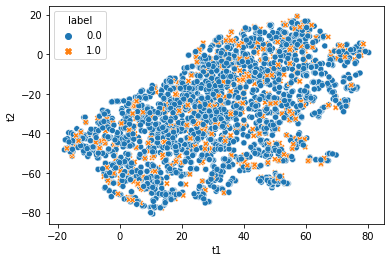

In [212]:
import seaborn as sns
sns.scatterplot(data=dff, x="t1", y="t2", hue="label",style="label")

In [ ]:
l